# Audio Sentiment analysis project

In [35]:
import torch
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchaudio.backend as backend

# Check available backends
torchaudio.set_audio_backend("sox_io")


/tmp/ipykernel_3924/3171038256.py:13: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [36]:
datasetRAVDEES = "dataset/data/RAVDEES/"
datasetCREMAD = "dataset/data/CREMA-D/AudioWAV/"
datasetTESS = "dataset/data/TESS/TESS Toronto emotional speech set data/"

Using the naming schema to segregate our data into different emotions. We will first start with RAVDEES

RAVDESS is one of the most common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
2. Vocal channel (01 = speech, 02 = song).
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
4. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
5. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).
7. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

1. Video-only (02)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12) - Female (as the actor ID number is even)


                                                file    emotion
0  dataset/data/RAVDEES/Actor_21/03-01-06-01-02-0...    fearful
1  dataset/data/RAVDEES/Actor_21/03-01-04-02-02-0...        sad
2  dataset/data/RAVDEES/Actor_21/03-01-08-02-02-0...  surprised
3  dataset/data/RAVDEES/Actor_21/03-01-05-01-01-0...      angry
4  dataset/data/RAVDEES/Actor_21/03-01-07-02-01-0...    disgust


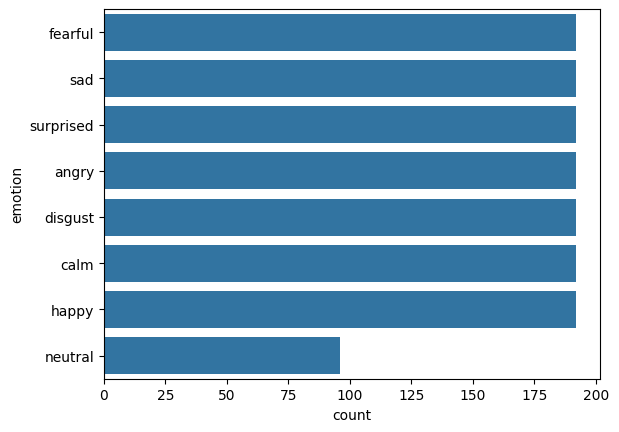

In [37]:
### We will use the naming schema for ravdees dataset and see if we can get the representing emotion for that specific audio file
def create_ravdess_dataframe(root_dir):
    # Initialize an empty list to store data
    data = []

    # Traverse through the directory structure
    for actor_dir in os.listdir(root_dir):
        actor_path = os.path.join(root_dir, actor_dir)
        if os.path.isdir(actor_path):
            for filename in os.listdir(actor_path):
                # Check if filename follows the expected format
                if filename.endswith('.wav') and filename.count('-') == 6:
                    # Extract information from the filename
                    file_info = filename.split('.')[0].split('-')
                    modality = int(file_info[0])
                    vocal_channel = int(file_info[1])
                    emotion = int(file_info[2])
                    intensity = int(file_info[3])
                    statement = int(file_info[4])
                    repetition = int(file_info[5])
                    actor_id = int(file_info[6])

                    # Determine emotion label
                    if emotion == 1:
                        emotion_label = 'neutral'
                    elif emotion == 2:
                        emotion_label = 'calm'
                    elif emotion == 3:
                        emotion_label = 'happy'
                    elif emotion == 4:
                        emotion_label = 'sad'
                    elif emotion == 5:
                        emotion_label = 'angry'
                    elif emotion == 6:
                        emotion_label = 'fearful'
                    elif emotion == 7:
                        emotion_label = 'disgust'
                    elif emotion == 8:
                        emotion_label = 'surprised'

                    # Append file path and emotion to the data list
                    file_path = os.path.join(actor_path, filename)
                    data.append((file_path, emotion_label))
                
    # Create a DataFrame object from the data list
    df = pd.DataFrame(data, columns=['file', 'emotion'])
    
    return df

### test the method
df = create_ravdess_dataframe(datasetRAVDEES)
print(df.head())
sns.countplot(df['emotion'])
plt.show()



In [38]:
### Similarly we write a method fir the CREMAD dataset and append to our df
def create_cremad_dataframe(root_dir, df):
    dirr = os.listdir(root_dir)
    for file in dirr:
        if not file.endswith('.wav'):
            continue
        nameSplit = file.split('_')
        emotion = nameSplit[2]
        if emotion == 'SAD':
            emotion = 'sad'
        elif emotion == 'ANG':
            emotion = 'angry'
        elif emotion == 'DIS':
            emotion = 'disgust'
        elif emotion == 'FEA':
            emotion = 'fearful'
        elif emotion == 'HAP':
            emotion = 'happy'
        elif emotion == 'NEU':
            emotion = 'neutral'
        elif emotion == 'SUR':
            emotion = 'surprised'
            
        # Create DataFrame for the current file
        new_df = pd.DataFrame({'file': [os.path.join(root_dir, file)], 'emotion': [emotion]})
        
        # Concatenate new DataFrame with existing DataFrame
        df = pd.concat([df, new_df], ignore_index=True)
        
    # Remove duplicate rows based on file path
    df = df.drop_duplicates(subset=['file'])
    
    return df


print(len(df))
print(df.columns)
df = create_cremad_dataframe(datasetCREMAD, df)
print(len(df))

#sorted_emotions = df['emotion'].sort_values(ascending=False).index

'''sns.countplot(df['emotion'])
plt.show()
print(df['emotion'].value_counts())'''

### now similarly we do the same for the TESS dataset


1440
Index(['file', 'emotion'], dtype='object')
8882


"sns.countplot(df['emotion'])\nplt.show()\nprint(df['emotion'].value_counts())"

8882
emotion
angry                 1863
disgust               1863
happy                 1863
fearful               1663
sad                   1663
neutral               1583
Fear                   200
Sad                    200
pleasant_surprised     200
Pleasant_surprise      200
surprised              192
calm                   192
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='emotion'>

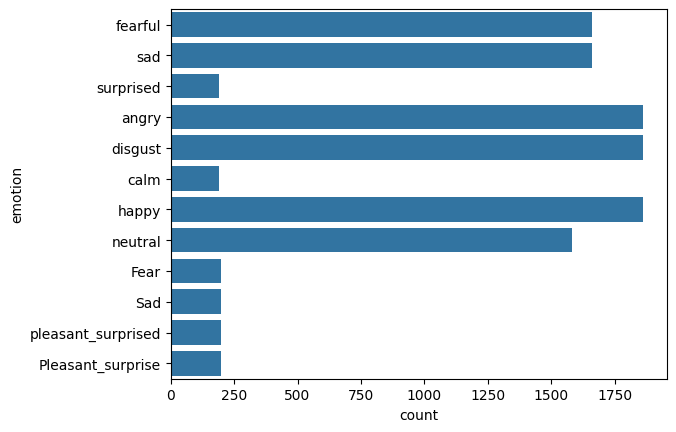

In [39]:
#### Similarly we will create the dataframe for the TESS dataset
def create_tess_dataframe(root_dir, df):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):
                # Extract emotion label from the parent directory
                emotion = os.path.basename(root)
                
                # Map emotion labels to standard emotions
                if emotion.startswith('YAF'):
                    # Remove speaker identifier for Young Female speakers
                    emotion = emotion[4:]
                elif emotion.startswith('OAF'):
                    # Remove speaker identifier for Old Female speakers
                    emotion = emotion[4:]
                elif emotion.startswith('YAF'):
                    # Remove speaker identifier for Young Male speakers
                    emotion = emotion[4:]
                elif emotion.startswith('OAF'):
                    # Remove speaker identifier for Old Male speakers
                    emotion = emotion[4:]

                # Map emotion labels to standard emotions
                if emotion == 'angry':
                    emotion = 'angry'
                elif emotion == 'disgust':
                    emotion = 'disgust'
                elif emotion == 'fear':
                    emotion = 'fearful'
                elif emotion == 'happy':
                    emotion = 'happy'
                elif emotion == 'neutral':
                    emotion = 'neutral'
                elif emotion == 'sad':
                    emotion = 'sad'
                elif emotion == 'ps':
                    emotion = 'surprised'

                # Append file path and emotion to the DataFrame
                df = pd.concat([df, pd.DataFrame({'file': [os.path.join(root, file)], 'emotion': [emotion]})], ignore_index=True)
    
    # Remove duplicate rows based on file path
    df = df.drop_duplicates(subset=['file'])
    
    return df

df_final = create_tess_dataframe(datasetTESS, df)
print(len(df))
print(df_final['emotion'].value_counts())
sns.countplot(df_final['emotion'])

8882
emotion
fearful      1863
sad          1863
angry        1863
disgust      1863
happy        1863
neutral      1775
surprised     592
Name: count, dtype: int64


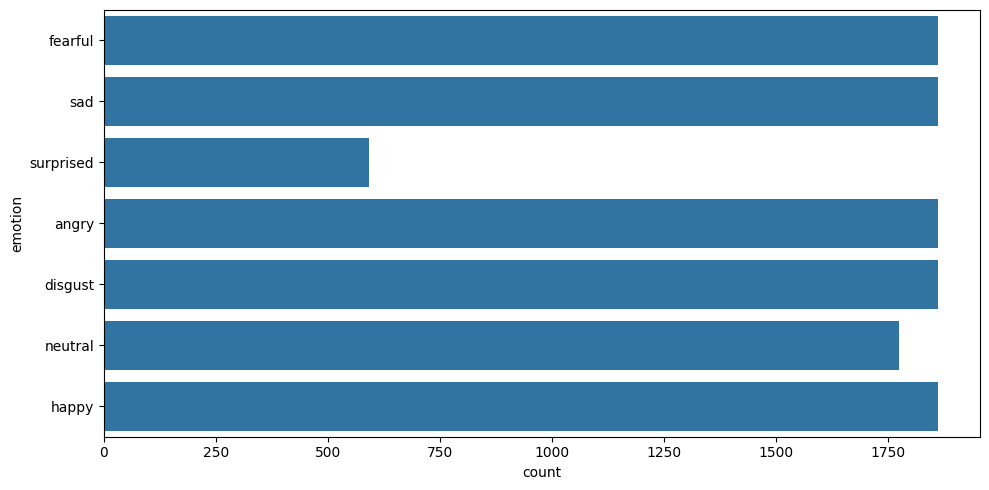

In [40]:
def combine_emotion_labels(emotion):
    if emotion.lower() in ['fear', 'fearful']:
        return 'fearful'
    elif emotion.lower() in ['sad', 'Sad']:
        return 'sad'
    elif emotion.lower() in ['pleasant_surprised', 'Pleasant_surprise', 'surprised', 'pleasant_surprise']:
        return 'surprised'
    elif emotion.lower() in ['calm']:
        return 'neutral'
    else:
        return emotion.lower()

# Apply the function to the 'emotion' column
df_final['emotion'] = df_final['emotion'].apply(combine_emotion_labels)

print(len(df))
print(df_final['emotion'].value_counts())
plt.figure(figsize=(10, 5))
sns.countplot(df_final['emotion'])
plt.tight_layout()
plt.show()

As we can see there is an imbalance of `surprise` we will be assigning class weights to help us handle the imbalance of data. We will first handle preprocessing of the audio files. We will be analysing the spectrograms and waveform and plot them in a grid. One for each emotion and we will try to figure out ways to add noise in audio. 

{'angry': 0, 'disgust': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
                                                file    emotion  label
0  dataset/data/RAVDEES/Actor_21/03-01-06-01-02-0...    fearful      2
1  dataset/data/RAVDEES/Actor_21/03-01-04-02-02-0...        sad      5
2  dataset/data/RAVDEES/Actor_21/03-01-08-02-02-0...  surprised      6
3  dataset/data/RAVDEES/Actor_21/03-01-05-01-01-0...      angry      0
4  dataset/data/RAVDEES/Actor_21/03-01-07-02-01-0...    disgust      1
5  dataset/data/RAVDEES/Actor_21/03-01-02-01-02-0...    neutral      4
6  dataset/data/RAVDEES/Actor_21/03-01-03-02-01-0...      happy      3


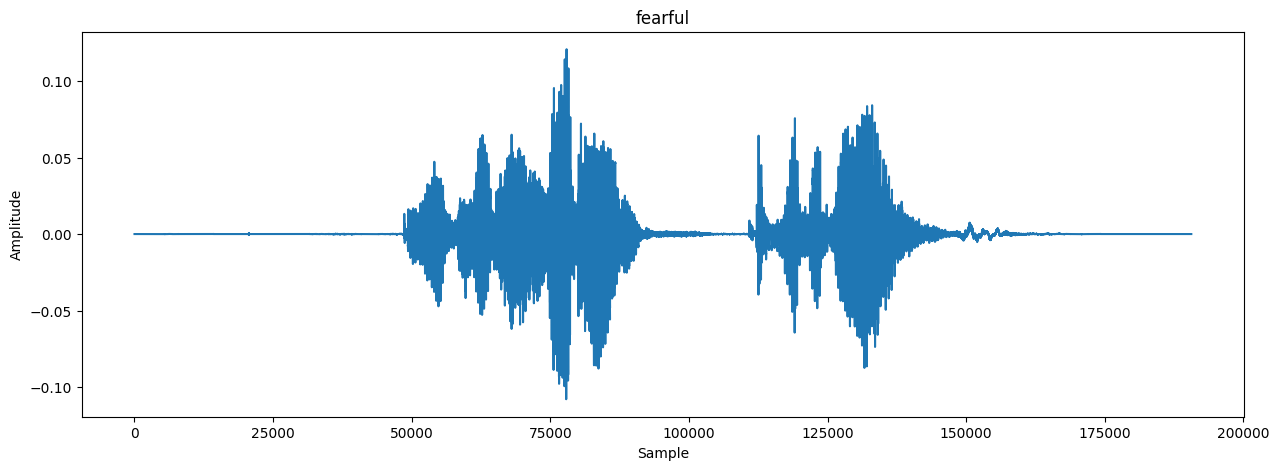

In [41]:
df_final['emotion'].unique()
### we will also encode the emotions to numerical values and store their mapping in a dictionary
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_final['label'] = encoder.fit_transform(df_final['emotion'])
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_mapping)

data_to_plot = df_final.head(7)
print(data_to_plot)

def plot_waveform(file_path, emotion):
    waveform, sample_rate = torchaudio.load(file_path, format='wav')
    plt.figure(figsize=(15, 5))
    plt.plot(waveform.t().numpy())
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title(emotion)
    plt.show()
    
file_path = 'dataset/data/RAVDEES/Actor_21/03-01-06-01-02-01-21.wav'

# Try loading the audio file and catch any exceptions
try:
    waveform, sample_rate = torchaudio.load(file_path)
except Exception as e:
    print("Error:", e)
    
plot_waveform(data_to_plot['file'][0], data_to_plot['emotion'][0])



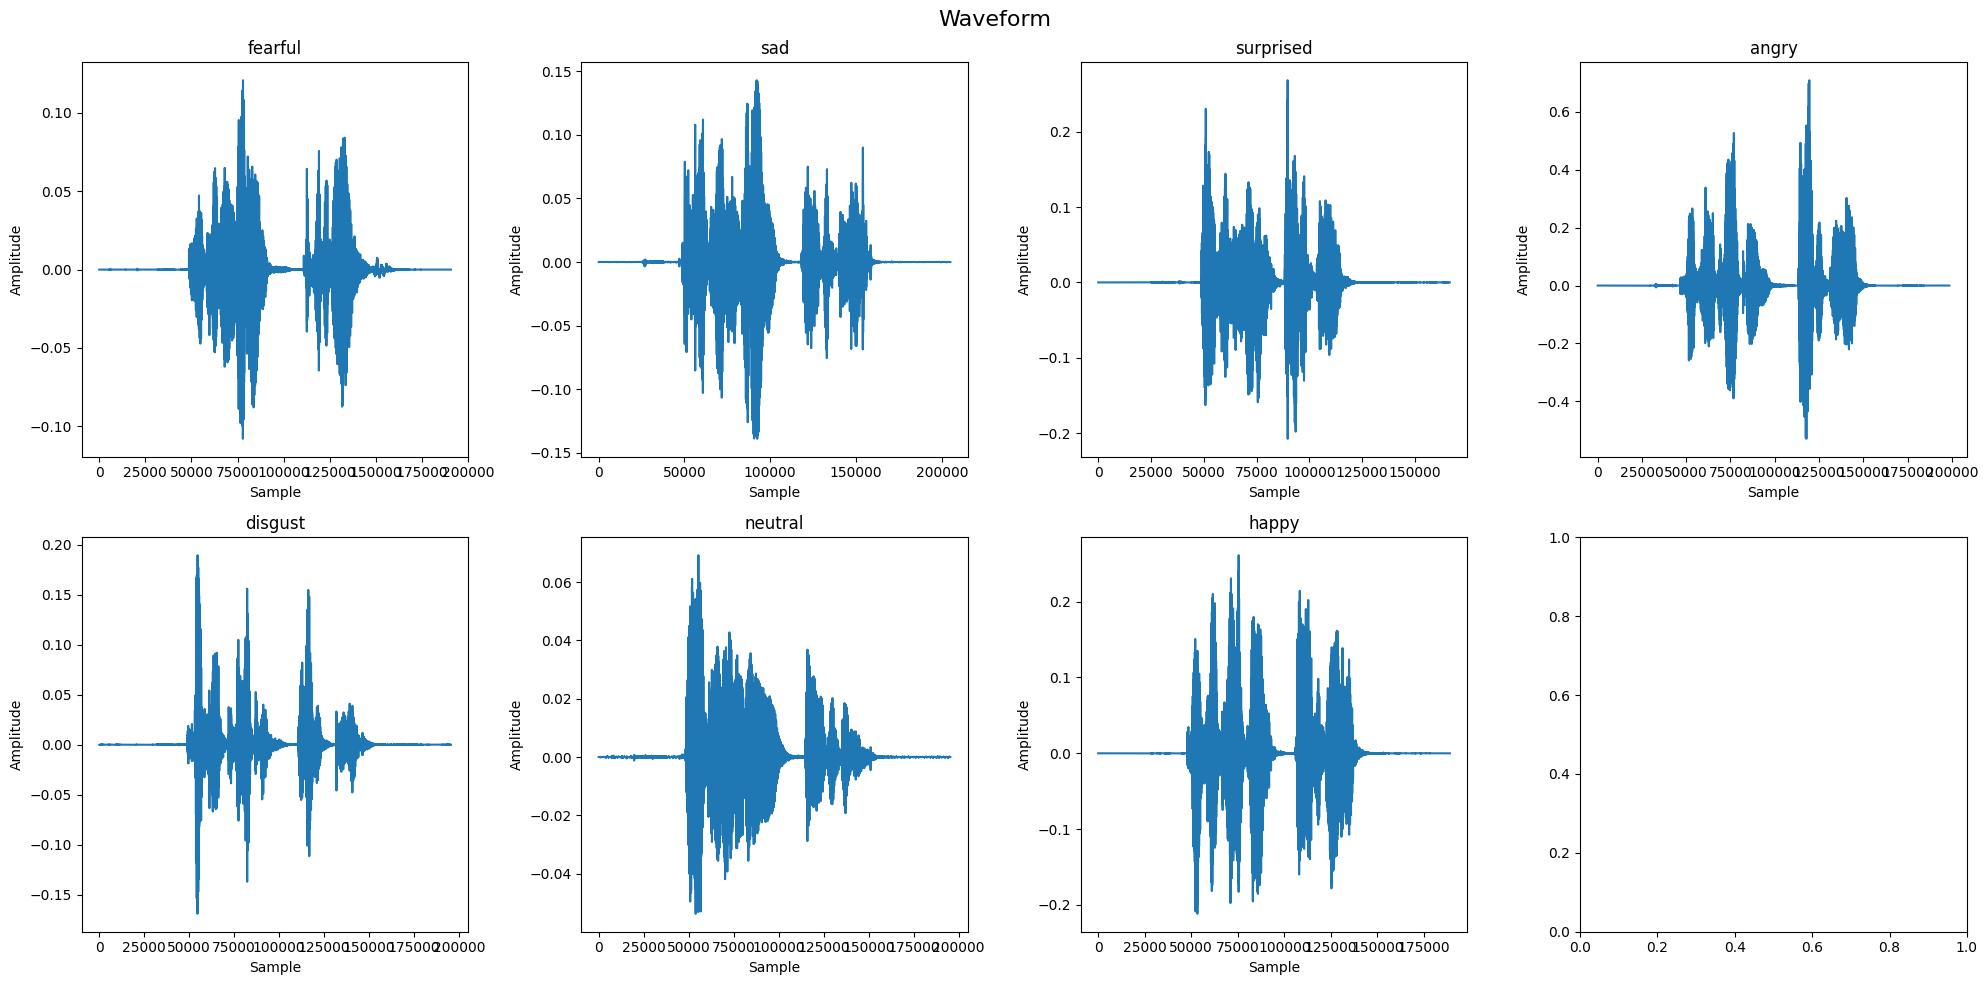

In [42]:
#### now we will be plotting the waveform for the first 7 audio files in the dataset in a grid 

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Waveform', fontsize=16)

for i in range(7):
    waveform, sample_rate = torchaudio.load(data_to_plot['file'][i])
    axs[i // 4, i % 4].plot(waveform.t().numpy())
    axs[i // 4, i % 4].set_title(data_to_plot['emotion'][i])
    axs[i // 4, i % 4].set_xlabel('Sample')
    axs[i // 4, i % 4].set_ylabel('Amplitude')
    
plt.tight_layout()
plt.show()

In [43]:
import librosa



def extract_features(data, sample_rate):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    mel_spec = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate, n_fft=2048, hop_length=512).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data, frame_length=2048, hop_length=512).T, axis=0)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate, n_fft=2048, hop_length=512).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=data, frame_length=2048, hop_length=512).T, axis=0)
    return np.hstack((mfcc, mel_spec, zcr, spec_centroid, rms))


def preprocess_audio_file(filepath):
    waveform, sample_rate = torchaudio.load(filepath)
    ### take waveform and have it be mono audio
    '''waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    spec = torchaudio.transforms.MelSpectrogram()(waveform)   ''' 
    spec = extract_features(waveform[0].numpy(), sample_rate)
    return spec
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram[0]), origin="lower", aspect="auto", interpolation="nearest")
    
def preprocess_audio_file_waveform(filepath):
    waveform, sample_rate = torchaudio.load(filepath)
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    return waveform
    
i = 1
npydata = preprocess_audio_file(data_to_plot['file'][i])
print(npydata.shape)

###plot the numpy array
'''plt.figure(figsize=(10, 5))
plt.imshow(librosa.power_to_db(npydata[0]), origin="lower", aspect="auto", interpolation="nearest")
plt.show()

npydata_wave = preprocess_audio_file_waveform(data_to_plot['file'][i]).numpy()
print(npydata_wave.shape)'''



(144,)


'plt.figure(figsize=(10, 5))\nplt.imshow(librosa.power_to_db(npydata[0]), origin="lower", aspect="auto", interpolation="nearest")\nplt.show()\n\nnpydata_wave = preprocess_audio_file_waveform(data_to_plot[\'file\'][i]).numpy()\nprint(npydata_wave.shape)'

### Preprocessing the data

In [44]:
from multiprocessing import Pool
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import tqdm, time
from dask import delayed, compute


def preprocess_data_dask(filepaths, num_cpus):
    with LocalCluster(n_workers=num_cpus) as cluster, Client(cluster) as client:
        specs = []
        for filepath in tqdm.tqdm(filepaths):
            spec = preprocess_audio_file(filepath)
            specs.append(spec)
    return specs

# Load data using Dask in parallel
filepaths = df_final['file'].values.flatten().tolist()

CPU Count: 2


100%|██████████| 11682/11682 [02:43<00:00, 71.59it/s]


CPU Count: 4


100%|██████████| 11682/11682 [03:11<00:00, 60.86it/s]


CPU Count: 8


100%|██████████| 11682/11682 [03:18<00:00, 58.76it/s]


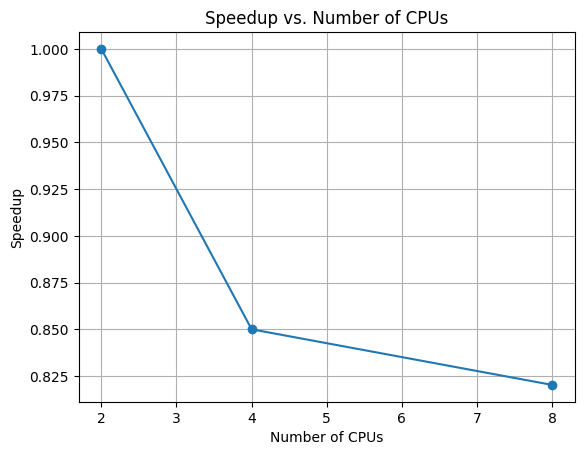

In [45]:



# Define the range of CPUs to test
#cpu_range = range(1, 9)
cpu_range = [2,4,8]

# Measure execution time for different numbers of CPUs
execution_times = []
for num_cpus in cpu_range:
    print("CPU Count:", num_cpus)
    start_time = time.time()
    specs = preprocess_data_dask(filepaths, num_cpus)
    end_time = time.time()
    execution_times.append(end_time - start_time)

# Plot the speedup
plt.plot(cpu_range, [execution_times[0] / time for time in execution_times], marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.title('Speedup vs. Number of CPUs')
plt.grid(True)
plt.show()

# Preprocess all the files for easy access

We will preprocess the files and save them as a `.pkl` file.

In [46]:
'''### save the npy file
specs = preprocess_data_dask(filepaths, 6)

### we will also save the file to a npy file'''

### we will check if the file is saved else we will preprocess the data and save it or load it
if os.path.exists('processed_data.npy'):
    print("Loading the data from the file...")
    specs = np.load('processed_data.npy', allow_pickle=True)
else:
    print("Preprocessing the data and saving it to a file...")
    specs = preprocess_data_dask(filepaths, 6)
    np.save('processed_data.npy', specs)

Loading the data from the file...


In [47]:

print(len(specs))
print("Printing the mx shape of the first numpy: ",specs[0].shape)
print(specs[0].dtype)
#### print the max shape of specs
max_shape = max([spec.shape for spec in specs])
print("Printing the max shape of the numpy: ", max_shape)

### we will create a dataframe to store the array along with the emotion label
data_processed = pd.DataFrame(specs, columns=['f' + str(i) for i in range(max_shape[0])])
data_processed['emotion'] = df_final['label']

print(data_processed.head())

11682
Printing the mx shape of the first numpy:  (144,)
float64
Printing the max shape of the numpy:  (144,)
           f0         f1         f2         f3         f4         f5  \
0 -605.542480  71.944672  -1.672075  12.170442   5.372849  16.081848   
1 -576.340454  81.464630  -4.920582   7.755494  10.993712  15.704956   
2 -561.738159  63.771156  -8.193513  10.717543   1.528304  11.123491   
3 -475.296082  72.554428 -15.413278   7.009411   7.358938  10.749163   
4 -626.364380  85.229454  -3.581933   9.515907   7.661771  19.551548   

          f6        f7        f8         f9  ...      f135          f136  \
0  -7.040884  5.336703 -2.371199  -6.020412  ...  0.000003  1.908908e-06   
1  -9.740493 -5.324623 -0.982889 -11.599356  ...  0.000001  8.022030e-07   
2  -9.027408 -1.619140 -2.938692  -9.928778  ...  0.000005  3.351279e-06   
3 -12.728761 -2.463967  0.022742  -9.997449  ...  0.000011  9.831679e-06   
4  -8.907881  4.193798  1.711481  -6.687214  ...  0.000001  1.206036e-06   

 

# Modelling

Now we will be passing the features to train a model

In [48]:
from torchvision import  models
from torch import nn
from torch.nn import functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

'''class CustomResNet(nn.Module):
    def __init__(self, num_features, num_classes=7):
        super(CustomResNet, self).__init__()
        # Load a pre-trained ResNet-50 model
        self.resnet = models.resnet50(pretrained=True)
        # Replace the first layer with a fully connected layer
        self.resnet.fc = nn.Linear(num_features, self.resnet.fc.in_features)
        # Freeze the parameters of the model except the new layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc.requires_grad = True
        # Replace the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),    
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.resnet(x)
        return x'''
    
class Network(nn.Module):
    def __init__(self, num_features, num_classes=7):
        super(Network, self).__init__()
        # Define the layers
        self.layers = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class SimpleNetwork(nn.Module):
    def __init__(self, num_features, num_classes=7):
        super(SimpleNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [49]:
features = data_processed.drop('emotion', axis=1).values
targets = data_processed['emotion'].values

print("Features shape:", features.shape)
print("Targets shape:", targets.shape)

# Normalize your features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert your DataFrame to PyTorch tensors
features = torch.tensor(features, dtype=torch.float)
targets = torch.tensor(targets, dtype=torch.long)

# Split your data into training and validation sets
features_train, features_val, targets_train, targets_val = train_test_split(features, targets, test_size=0.2, random_state=42)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(features_train, targets_train)
val_dataset = TensorDataset(features_val, targets_val)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

Features shape: (11682, 144)
Targets shape: (11682,)


Epoch 1/50, Training Loss: 1.983773313973048, Training Accuracy: 24.81806506849315
Epoch 1/50, Validation Loss: 1.7323300981358305, Validation Accuracy: 31.335616438356166
Epoch 2/50, Training Loss: 1.8875980720128098, Training Accuracy: 28.339041095890412
Epoch 2/50, Validation Loss: 1.6877861831286183, Validation Accuracy: 28.55308219178082
Epoch 3/50, Training Loss: 1.8337991925543302, Training Accuracy: 31.01455479452055
Epoch 3/50, Validation Loss: 1.6520700960943144, Validation Accuracy: 30.86472602739726
Epoch 4/50, Training Loss: 1.7787691500701317, Training Accuracy: 33.18707191780822
Epoch 4/50, Validation Loss: 1.7265281730318722, Validation Accuracy: 25.42808219178082
Epoch 5/50, Training Loss: 1.74558108871522, Training Accuracy: 35.40239726027397
Epoch 5/50, Validation Loss: 1.6263653819691646, Validation Accuracy: 30.607876712328768
Epoch 6/50, Training Loss: 1.7043663310269788, Training Accuracy: 37.853167808219176
Epoch 6/50, Validation Loss: 1.4069844208759805, Valida

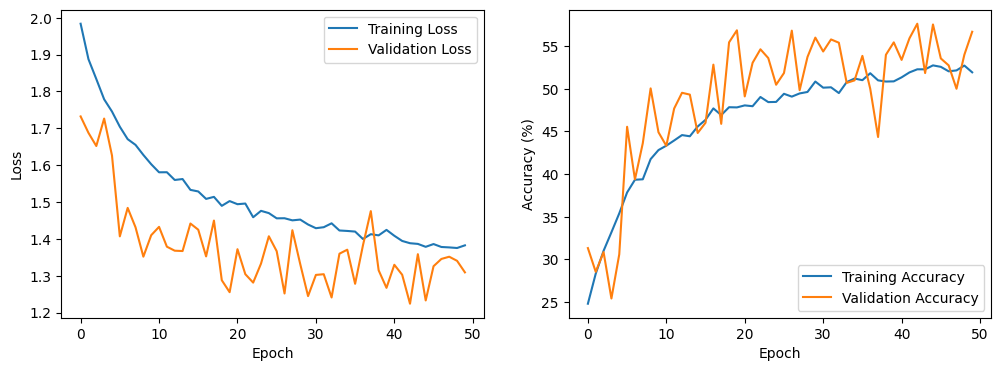

In [50]:
from sklearn.utils.class_weight import compute_class_weight

#unique_classes = np.unique(targets)

# Compute class weights
#class_weights = compute_class_weight('balanced', classes=unique_classes, y=targets)

# Convert class weights to a PyTorch tensor
#class_weights = torch.tensor(class_weights, dtype=torch.float)

### we train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features_shape = features.shape[1]

#model = Network(num_features=features_shape, num_classes=7).to(device)
model = Network(num_features=features_shape, num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

### we will use mixed precision training
scaler = torch.cuda.amp.GradScaler()

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
warmup_epoch = 10

initial_lr = 0.01
gamma = 0.95

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(features)
            loss = criterion(outputs, targets)
            # Add L2 regularization
            l2_reg = None
            for param in model.parameters():
                if l2_reg is None:
                    l2_reg = param.norm(2)
                else:
                    l2_reg = l2_reg + param.norm(2)
            loss = loss + 0.001 * l2_reg  # You can adjust the regularization strength
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader)}, Training Accuracy: {100 * correct_train / total_train}")

    # Step the learning rate scheduler
    #scheduler.step()
    if epoch < warmup_epoch:
        lr = 0.01 * (epoch + 1) / warmup_epoch
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {100 * correct_val / total_val}")
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

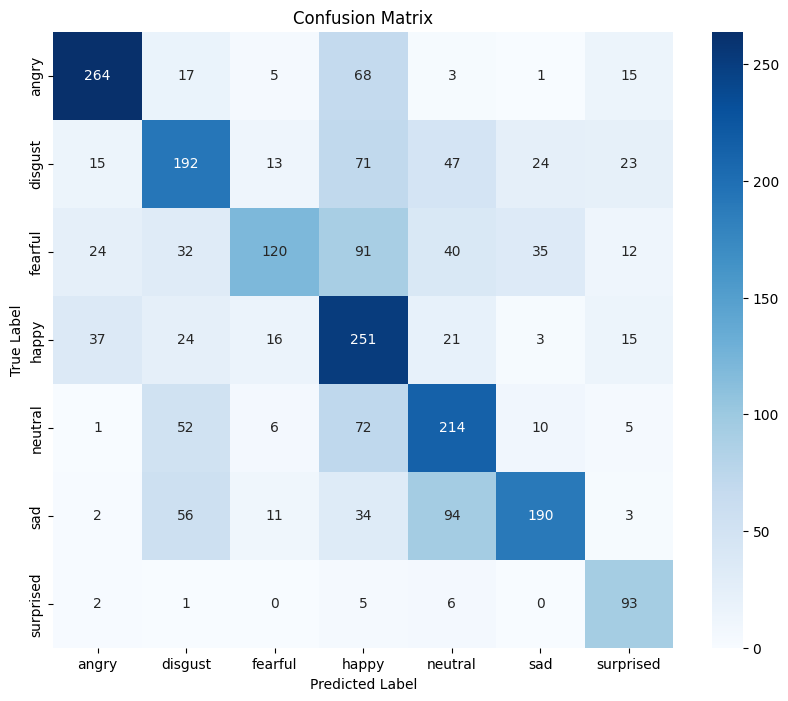

In [51]:
### we plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
targets_all = []
outputs_all = []
with torch.no_grad():
    for features, targets in val_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(predicted.cpu().numpy())
        
cm = confusion_matrix(targets_all, outputs_all)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Using DataParallel for training

In [54]:
import torch
from torch.nn.parallel import DataParallel as DP
import torch.multiprocessing as mp

def train(features):
    print("Starting training...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, else CPU
    features_shape = features.shape[1]
    model = SimpleNetwork(num_features=features_shape, num_classes=7).to(device)

    if torch.cuda.device_count() > 1:  # If more than one GPU available
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = DP(model)  # Wrap model with DP

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    num_epochs = 50
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}...")
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss / len(train_loader)}, Training Accuracy: {100 * correct_train / total_train}")

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {100 * correct_val / total_val}")

    print("Saving model...")
    try:
        if isinstance(model, torch.nn.DataParallel):
            torch.save(model.module.state_dict(), 'model.pth')  # If model is DataParallel
        else:
            torch.save(model.state_dict(), 'model.pth')  # If model is not DataParallel
        print("Model saved successfully.")
    except Exception as e:
        print("Error occurred while saving the model:", e)

if __name__ == '__main__':
    
    # Assuming the necessary configurations for train_dataset, val_dataset, features_shape, batch_size, etc.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train(features)

# Load the trained model for further usage
model = SimpleNetwork(num_features=features_shape, num_classes=7)
model.load_state_dict(torch.load('model.pth'))
model.eval()

Starting training...
Starting epoch 1/50...
Epoch 1/50, Training Loss: 1.8367977542715057, Training Accuracy: 23.071161048689138
Epoch 1/50, Validation Loss: 1.726508349281936, Validation Accuracy: 31.70731707317073
Starting epoch 2/50...
Epoch 2/50, Training Loss: 1.6850891634375749, Training Accuracy: 31.021936864633492
Epoch 2/50, Validation Loss: 1.5523495413744408, Validation Accuracy: 34.91655969191271
Starting epoch 3/50...
Epoch 3/50, Training Loss: 1.5692529068021717, Training Accuracy: 36.3509898341359
Epoch 3/50, Validation Loss: 1.4547110873277684, Validation Accuracy: 43.94522892597347
Starting epoch 4/50...
Epoch 4/50, Training Loss: 1.494704652383248, Training Accuracy: 40.25682182985554
Epoch 4/50, Validation Loss: 1.363276860412884, Validation Accuracy: 47.36842105263158
Starting epoch 5/50...
Epoch 5/50, Training Loss: 1.42964902838853, Training Accuracy: 43.04975922953451
Epoch 5/50, Validation Loss: 1.314591114228089, Validation Accuracy: 49.46512623020967
Starting 

SimpleNetwork(
  (layers): Sequential(
    (0): Linear(in_features=144, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=7, bias=True)
    (10): LogSoftmax(dim=1)
  )
)

# ONNX

We will finally save the model in ONNX format for further optimizations

In [ ]:
### here we will convert the model to ONNX format and use tensorrt to optimize the model
## first ONNX format conversion

import torch.onnx
import onnx
import onnxruntime as ort

# Define the input and output names
input_names = ['input']
output_names = ['output']

# Export the model to ONNX
torch.onnx.export(model, features[:1], 'model.onnx', input_names=input_names, output_names=output_names, verbose=True)

# Load the ONNX model
onnx_model = onnx.load('model.onnx')

# Print a human-readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

# TensorRT optimizations

We will try and implement TensorRT to our current ONNX model optimization and check the inference speed. First we will pass it sample data and see the normal ONNX model throughput speed

In [60]:
def predict(features):
    # Load the ONNX model
    onnx_model = onnx.load('model.onnx')
    ort_session = ort.InferenceSession('model.onnx')
    features = features.cpu().numpy().astype(np.float32)  # Move tensor to CPU before converting to numpy
    input_data = {'input': features}
    outputs = ort_session.run(None, input_data)
    return outputs

# Predict the output using the ONNX model and check the speed
features = features_val[:1]
start_time = time.time()
outputs = predict(features)
end_time = time.time()
print("Time taken for prediction using ONNX:", end_time - start_time)

print(np.argmax(outputs[0]))

### we also compare the speed of non onnx model
def predict_torch(features):
    model.to(device)  # Move the model to the device
    features = features.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(features)
    return outputs

# Predict the output using the PyTorch model and check the speed
features = features_val[:1].to(device)
start_time = time.time()
outputs = predict_torch(features)
end_time = time.time()
print("Time taken for prediction using PyTorch:", end_time - start_time)

print(torch.argmax(outputs[0]))

Time taken for prediction using ONNX: 0.006657123565673828
1
Time taken for prediction using PyTorch: 0.0013849735260009766
tensor(1, device='cuda:0')


As we can see ONNX model took a longer time so we will use tensorRT to speedup inference speed

In [62]:
'''### now we will use tensorrt to optimize the model
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

def build_engine(onnx_path, engine_path):
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
        builder.max_workspace_size = 1 << 30  # 1GB
        builder.max_batch_size = 1
        with open(onnx_path, 'rb') as model:
            if not parser.parse(model.read()):
                for error in range(parser.num_errors):
                    print(parser.get_error(error))
                return None
        engine = builder.build_cuda_engine(network)
        with open(engine_path, 'wb') as model:
            model.write(engine.serialize())
        return engine
    
def load_engine(engine_path):
    with open(engine_path, 'rb') as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())
    
def predict_trt(engine, features):
    context = engine.create_execution_context()
    inputs, outputs, bindings, stream = [], [], [], cuda.Stream()
    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        # Allocate device memory
        inputs.append(cuda.mem_alloc(size * dtype.itemsize))
        outputs.append(cuda.mem_alloc(size * dtype.itemsize))
        bindings.append(int(inputs[-1]))
    # Transfer input data to the GPU
    cuda.memcpy_htod(inputs[0], features.numpy().astype(dtype))
    # Run inference
    context.execute_async(bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back
    cuda.memcpy_dtoh(outputs[0], outputs[0])
    return outputs

# Build the TensorRT engine
engine = build_engine('model.onnx', 'model.trt')

# Load the TensorRT engine
engine = load_engine('model.trt')

# Predict the output using the TensorRT engine and check the speed
features = features_val[:1]
start_time = time.time()
outputs = predict_trt(engine, features)
end_time = time.time()
print("Time taken for prediction using TensorRT:", end_time - start_time)

print(np.argmax(outputs[0]))'''

'### now we will use tensorrt to optimize the model\nimport tensorrt as trt\nimport pycuda.driver as cuda\nimport pycuda.autoinit\n\nTRT_LOGGER = trt.Logger(trt.Logger.WARNING)\n\ndef build_engine(onnx_path, engine_path):\n    with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.OnnxParser(network, TRT_LOGGER) as parser:\n        builder.max_workspace_size = 1 << 30  # 1GB\n        builder.max_batch_size = 1\n        with open(onnx_path, \'rb\') as model:\n            if not parser.parse(model.read()):\n                for error in range(parser.num_errors):\n                    print(parser.get_error(error))\n                return None\n        engine = builder.build_cuda_engine(network)\n        with open(engine_path, \'wb\') as model:\n            model.write(engine.serialize())\n        return engine\n    \ndef load_engine(engine_path):\n    with open(engine_path, \'rb\') as f, trt.Runtime(TRT_LOGGER) as runtime:\n        return runtime.deserialize_cuda